c:\Users\ABC\AppData\Local\Programs\Python\Python310\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


(60, 59)
(60, 59)
(60, 1)
(1, 60)
(60, 1)
(60, 1)
(60, 1)
(60, 60)
(59, 1)
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
A01: Products of agriculture, hunting and related services
A02: Products of forestry, logging and related services
A03: Fish and other fishing products; aquaculture products; support services to fishing
B: Mining and quarrying
C10T12: Food products, beverages and tobacco products
C13T15: Textiles, wearing apparel and leather products
C16: Wood and of products of wood and cork, except furniture; articles of straw and plaiting materials
C17: Paper and paper products
C18: Printing and recording services
C19: Coke and refined petroleum products 
C20-21: Chemicals and chemical products AND Basic pharmaceutical products and pharmaceutical preparations
C22: Rubber and plastics products
C23: Other non-metallic minera

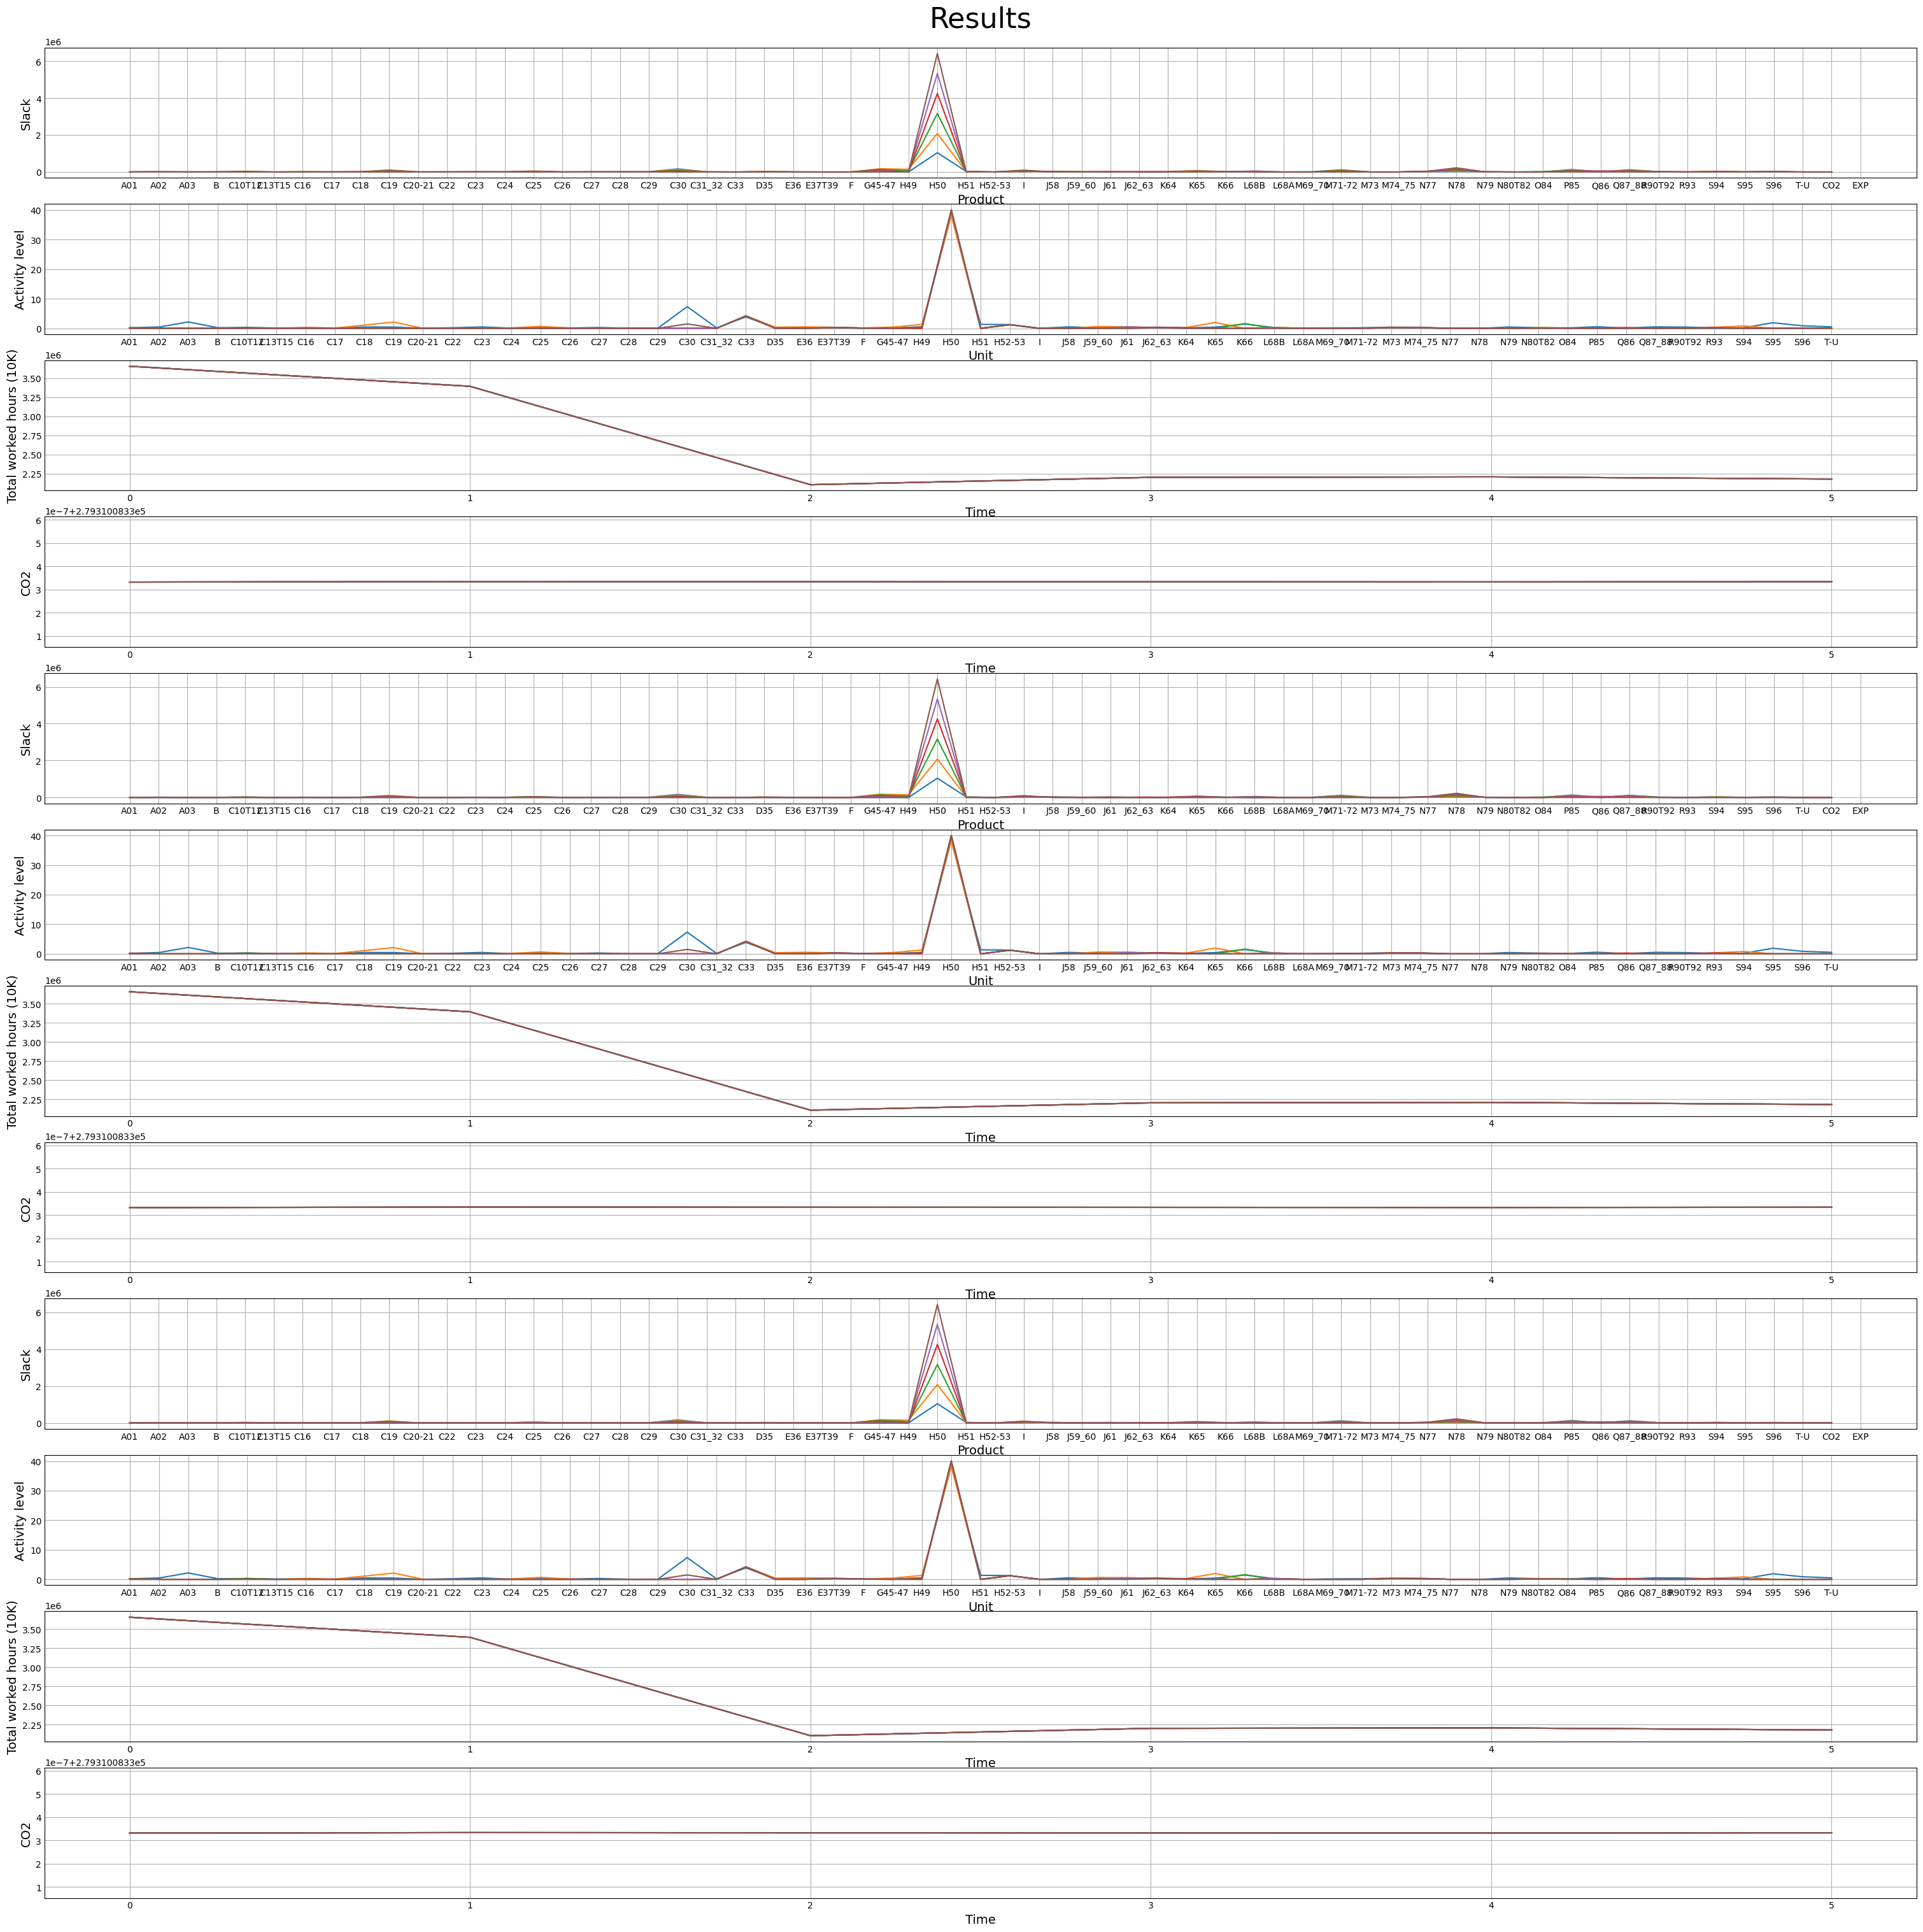

In [4]:
import sys 
sys.path.append("../../../rhp")
from rhp_plan import plan
from pathlib import Path
import openpyxl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from copy import deepcopy

#Excel information extraction
xlsx_file = Path('nrio_sut_181108.xlsx')
main_sheet = openpyxl.load_workbook(xlsx_file)['2016']
xlsx_file = Path('posternas_namn.xlsx')
shorthand_sheet = openpyxl.load_workbook(xlsx_file)['SUP10']

#Division with zero-exception
def zdivide(x, y):
    return np.divide(x, y, out=np.zeros_like(x), where=y!=0)

#List constructor
def matrix_list_maker(x, y):
    return ([np.matrix(x)]*y)    

# Generates a 2D list of values from an xlsx file, reading left to right, top to bottom.
class Sheet:
    def __init__(self, sheet, left: int, top: int, right: int, bottom: int):
        result_sheet = []
        coordinates = []
        for row in sheet.iter_rows(min_row=left, min_col=top, max_row=right, max_col=bottom):
            data = []
            pos = []
            for cell in row:
                data.append(cell.value)
                pos.append(cell)

            result_sheet.append(data)
            coordinates.append(pos)

        self.result = result_sheet
        self.coordinates = coordinates

    @property
    def np_array(self):
        return np.array(self.result, dtype=np.float64)

#Input values and list construction
time_steps = 3
planning_horizon = 6
step_horizon = time_steps + planning_horizon + 1
use_domestic = Sheet(main_sheet, 4, 3, 63, 61).np_array
use_imported = Sheet(main_sheet, 94, 3, 153, 61).np_array
supply = Sheet(main_sheet, 159, 3, 218, 61).np_array
export_vector = Sheet(main_sheet, 4, 78, 63, 78).np_array * time_steps * (1/12)
domestic_target_output = Sheet(main_sheet, 4, 79, 63, 79).np_array * (1/12)
imported_target_output = Sheet(main_sheet, 4, 81, 63, 81).np_array.reshape([1,-1]) * (1/12)
supply_use = supply - use_domestic 
export_prices = deepcopy(Sheet(main_sheet, 4, 80, 63, 80).np_array)
import_prices = deepcopy(Sheet(main_sheet, 4, 80, 63, 80).np_array)
depreciation = np.array(np.eye(N=supply.shape[0], M=supply.shape[0], k=0))
worked_hours = Sheet(main_sheet,69, 3, 69, 61).np_array.reshape([-1,1])

supply_use_list = matrix_list_maker(supply_use, step_horizon)
domestic_target_output_list = matrix_list_maker(domestic_target_output, step_horizon)
imported_target_output_list = matrix_list_maker(imported_target_output, step_horizon)
use_imported_list = matrix_list_maker(use_imported, step_horizon)
export_vector_list = matrix_list_maker(export_vector, step_horizon)
export_prices_list = matrix_list_maker(export_prices, step_horizon)
import_prices_list = matrix_list_maker(import_prices, step_horizon)
depreciation_list = matrix_list_maker(depreciation, step_horizon)
primary_resource_list = matrix_list_maker(worked_hours, step_horizon)

print(supply_use_list[0].shape)
print(use_imported_list[0].shape)
print(domestic_target_output_list[0].shape)
print(imported_target_output_list[0].shape)
print(export_vector_list[0].shape)
print(export_prices_list[0].shape)
print(import_prices_list[0].shape)
print(depreciation_list[0].shape)
print(primary_resource_list[0].shape)

print(type(supply_use_list[0]))
print(type(use_imported_list[0]))
print(type(domestic_target_output_list[0]))
print(type(imported_target_output_list[0]))
print(type(export_vector_list[0]))
print(type(export_prices_list[0]))
print(type(import_prices_list[0]))
print(type(depreciation_list[0]))
print(type(primary_resource_list[0]))

#Notation
shorthand = [[x[0][4:] if x[0].startswith('CPA_') else x[0], x[1]] for x in Sheet(shorthand_sheet, 7, 2, 65, 3).result]
sector = Sheet(main_sheet, 3, 3, 3, 61)
[print(f'{short}: {desc}') for short, desc in shorthand]
sector_name_input = deepcopy(sector.result[0])
sector_with_all_outputs_input = deepcopy(sector_name_input)
sector_with_all_outputs_input.append('CO2')
sector_with_all_outputs_and_EXP = deepcopy(sector_with_all_outputs_input)
sector_with_all_outputs_and_EXP.append('EXP')

export_constraint = False

#Plan
plan_outcome = plan(time_steps=time_steps, planning_horizon=planning_horizon, primary_resource_list=primary_resource_list, 
                    supply_use_list=supply_use_list, use_imported_list=use_imported_list, depreciation_list=depreciation_list, 
                    domestic_target_output_list=domestic_target_output_list, imported_target_output_list=imported_target_output_list, export_constraint=export_constraint, export_vector_list=export_vector_list, 
                    export_prices_list=export_prices_list, import_prices_list=import_prices_list)

# plan details
result_list = plan_outcome[0]
lagrange_list = plan_outcome[1]
slack_list = plan_outcome[2]

plt.style.use('_mpl-gallery')
fig = plt.figure(figsize=(30, 180))
fig.suptitle('Results', fontsize=32)
number_of_graphs = 4
gs = gridspec.GridSpec(number_of_graphs * time_steps * planning_horizon, 1)

labels = ['Slack',
            'Activity level',
            'Lagrange multiplier',
            'Worked hours (10K)',
            'CO2',
            'Total worked hours (10K)']

for i in range(time_steps):
    
    ax = fig.add_subplot(gs[i * number_of_graphs + 1, 0])
    ax.set_xlabel('Product', fontsize=14)
    ax.set_ylabel(labels[0], fontsize=14)
    ax.set_xticks(range(supply_use_list[i].shape[0]+1), sector_with_all_outputs_and_EXP)
    for j in range(planning_horizon):
        s = np.array_split(slack_list[i], planning_horizon)
        ax.plot(range(s[j].shape[0]), s[j])

    ax = fig.add_subplot(gs[i * number_of_graphs + 2, 0])
    ax.set_xlabel('Unit', fontsize=14)
    ax.set_ylabel(labels[1], fontsize=14)
    ax.set_xticks(range(supply_use_list[i].shape[1]), sector_name_input)
    for j in range(planning_horizon):
        x = np.array_split(result_list[i], planning_horizon)
        ax.plot(range(x[j].shape[0]), x[j])

    resulting_worked_hours = [] 
    x = np.array_split(result_list[i], planning_horizon)
    for j in range(planning_horizon):
        resulting_worked_hours.append(np.matmul(worked_hours.reshape([1,-1]), x[j]))
    ax = fig.add_subplot(gs[i * number_of_graphs + 3, 0])
    ax.set_xlabel('Time', fontsize=14)
    ax.set_ylabel(labels[5], fontsize=14)
    for j in range(planning_horizon):
        ax.plot(range(planning_horizon), resulting_worked_hours)

    co2 = deepcopy(supply_use_list[0][-1,:])
    resulting_co2 = [] 
    x = np.array_split(result_list[i], planning_horizon)
    for j in range(planning_horizon):
        resulting_co2.append(np.matmul(co2, x[j]).item(0))
    ax = fig.add_subplot(gs[i * number_of_graphs + 4, 0])
    ax.set_xlabel('Time', fontsize=14)
    ax.set_ylabel(labels[4], fontsize=14)
    for j in range(planning_horizon):
        ax.plot(range(planning_horizon), resulting_co2)

    # x = np.array_split(result_list[i], planning_horizon)
    # worked_hours_per_sector = []
    # for j in range(worked_hours.shape[0]):
    #     worked_hours_per_sector.append(x[0][j]*worked_hours[j])
    # ax = fig.add_subplot(gs[i * number_of_graphs + 5, 0])
    # ax.set_xlabel('Product', fontsize=14)
    # ax.set_ylabel(labels[3], fontsize=14)
    # ax.set_xticks(range(supply_use_list[i].shape[1]), sector_name_input)
    # for j in range(planning_horizon):
    #     x = np.array_split(result_list[i], planning_horizon)
    #     ax.plot(range(x[j].shape[0]), worked_hours_per_sector)

    # ax = fig.add_subplot(gs[i * number_of_graphs + 6, 0])
    # ax.set_xlabel('Product', fontsize=14)
    # ax.set_ylabel(labels[2], fontsize=14)
    # ax.set_xticks(range(len(sector_with_all_outputs_and_EXP)), sector_with_all_outputs_and_EXP)
    # for j in range(planning_horizon):
    #     l = np.array_split(lagrange_list[i], planning_horizon)
    #     ax.plot(range(l[j].shape[0]), l[j])

plt.show()
